# Survival Analysis

[Run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/SurvivalAnalysisPython/blob/master/01_light_bulb.ipynb)

## Introduction

This notebook presents four ways to represent a distribution: PMFs, CDFs, survival functions, and hazard functions.

These representations are equivalent in the sense that if you are given any of them, you can compute the others.  So you might wonder why we need four ways to represent the same information.  There are two reasons:

1. Each representation is useful for computing different values and answering different questions.  In this notebook I'll show you what each representation is good for.

2. In some cases we can use a sample to compute a PMF, and use the PMF to compute the other representations.  In other cases it is easier to estimate the hazard function and use it to compute the others.

In this notebook I will demonstrate the first process, starting with the PMF.  In the next notebook we'll see the second process, starting with the hazard function.

## Light bulb lifetimes

As a first example, I'll use I'll use data from an experiment that measures the lifetimes of 50 light bulbs.
I downloaded the data from from [this gist](https://gist.github.com/epogrebnyak/7933e16c0ad215742c4c104be4fbdeb1), which includes this documentation:

```
Dataset from:
    
V.J. Menon and D.C. Agrawal,  Renewal Rate of Filament Lamps: 
Theory and Experiment. Journal of Failure Analysis and Prevention. 
December 2007, p. 421, Table 2/
DOI: 10.1007/s11668-007-9074-9

Description:

An assembly of 50 new Philips (India) lamps with the 
rating 40 W, 220 V (AC) was taken and installed in the horizontal 
orientation and uniformly distributed over a lab area 11 m by 7 m. 

The assembly was monitored at regular intervals of 12 h to
look for failures. The instants of recorded failures were
called t‘ and a total of 32 data points were obtained such
that even the last bulb failed. 

Variables:

i - observation number
h - time in hours since experiment start
f - number of failed lamps at particular time h
K - number of surviving lamps  at particular time h
```

Because of the design of this experiment, we can consider the data to be a representative sample from the distribution of lifetimes, at least for light bulbs that are lit continuously.

The following cell downloads the data (thanks to Evgeny Pogrebnyak for making it available).  
If that fails, you should be able to [get it from my repository](https://github.com/AllenDowney/SurvivalAnalysisPython/raw/master/lamps.csv).

In [12]:
import os

datafile = 'lamps.csv'
if not os.path.exists(datafile):
    !wget https://gist.github.com/epogrebnyak/7933e16c0ad215742c4c104be4fbdeb1/raw/c932bc5b6aa6317770c4cbf43eb591511fec08f9/lamps.csv

We can use Pandas to load the data from the CSV file.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
df = pd.read_csv('lamps.csv', index_col=0)
df.head()

,h,f,K
i,,,
0,0,0,50
1,840,2,48
2,852,1,47
3,936,1,46
4,960,1,45


## PMF

This dataset is complete in the sense that the experiment ran until all light bulbs failed, so the lifetime for every bulb is known.
So we can use the data to estimate the probability mass function (PMF) of lifetimes.

To represent a PMF, I'll use a Pandas `Series` with the lifetimes (column `h`) as the index and the number of failures (column `f`) as the values.

In [15]:
pmf = df.set_index('h').f
pmf.head()

h
0      0
840    2
852    1
936    1
960    1
Name: f, dtype: int64

To normalize the PMF, we divide through by the total number of lightbulbs.

In [16]:
pmf = pmf / pmf.sum()

For a given lifetime, `t`, the PMF contains the fraction of lifetimes equal to `t`.
For example, we can compute the fraction of light bulbs that lasted 840 hours:

In [17]:
pmf[840]

0.04

Or the fraction equal to 1524 hours.

In [18]:
pmf[1524]

0.06

Here's what the PMF looks like.

In [19]:
def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    plt.gca().set(**options)
    plt.tight_layout()

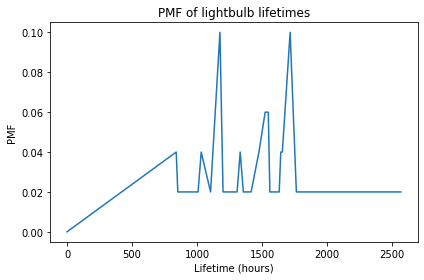

In [20]:
pmf.plot()
decorate(xlabel='Lifetime (hours)', 
         ylabel='PMF', 
         title='PMF of lightbulb lifetimes')

This way of visualizing the data can be useful for validation, and it gives a sense of the location and spread of the data.  But it does not make the shape of the distrbution clear.  For that, the CDF is better.

## CDF

The Cumulative Distribution Function (CDF) is the cumulative sum of the PMF.

In [21]:
cdf = pmf.cumsum()
cdf.head()

h
0      0.00
840    0.04
852    0.06
936    0.08
960    0.10
Name: f, dtype: float64

For a given lifetime, `t`, the CDF contains the fraction of lifetimes less than or equal to `t`.
For example, here is the fraction of light bulbs that expired at or before 840 hours:

In [22]:
cdf[840]

0.04

And the fraction that expired at or before 1524 hours.

In [23]:
cdf[1524]

0.6000000000000001

Here's what the CDF looks like.

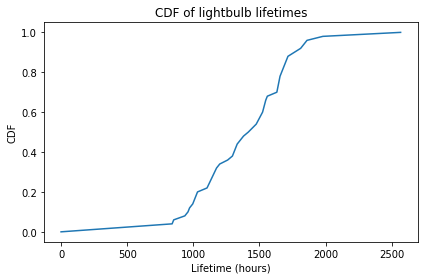

In [24]:
cdf.plot()
decorate(xlabel='Lifetime (hours)', 
         ylabel='CDF', 
         title='CDF of lightbulb lifetimes')

In my opinion, the CDF is often the best way to visualize the distribution of a sample.

Between 800 and 1800 hours, the CDF is roughly a straight line, which suggests that the distribution is uniform in this range.

## Survival function

The survival function is the complement of the CDF; that is, for a given lifetime, `t`:

* The CDF is the fraction of the population less than or equal to `t`.

* The survival function is the fraction (strictly) greater than `t`.

We can compute the survival function like this:

In [26]:
surv = 1 - cdf

We can use `surv` to compute the fraction of lightbulbs that live longer than 1524 hours:

In [27]:
surv[1524]

0.3999999999999999

If we plot the survival function along with the CDF, we can see that they are complements.

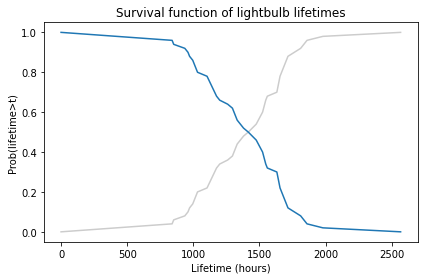

In [28]:
cdf.plot(color='gray', alpha=0.4)
surv.plot()
decorate(xlabel='Lifetime (hours)', 
         ylabel='Prob(lifetime>t)', 
         title='Survival function of lightbulb lifetimes')

It might not be obvious why the survival function is useful.  Given the CDF and a little arithmetic, we can answer all of the same questions.

There are two reasons:

* In some domains it is more natural, or at least conventional, to represent distributions in terms of survival rates.

* The survival function is a step on the way to the hazard function, which we'll get to now.

## Hazard function

For a given lifetime `t`, the hazard function computes the "hazard rate" at `t`.  Using the vocabulary of the light bulb example, the hazard rate is the fraction of light bulbs that survive until `t` and then fail at `t`.

We can compute the hazard rate by computing these quantities:

* `pmf(t)` is the fraction of light bulbs that fail at `t`.

* `surv(t)` is the fraction of light bulbs that live longer than `t`.

* The sum, `pmf(t) + surv(t)` is the fraction that survive until `t`. 

So the hazard rate is the ratio of `pmf(t)` to the sum `pmf(t) + surv(t)`.
We can compute it like this:

In [29]:
haz = pmf / (pmf + surv)
haz.head()

h
0      0.000000
840    0.040000
852    0.020833
936    0.021277
960    0.021739
Name: f, dtype: float64

Here's what the hazard function looks like:

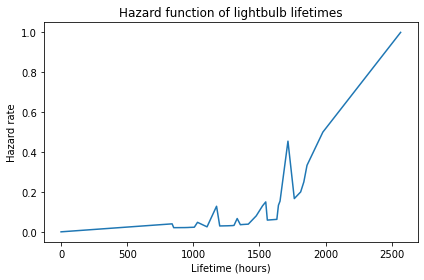

In [30]:
haz.plot()
decorate(xlabel='Lifetime (hours)', 
         ylabel='Hazard rate', 
         title='Hazard function of lightbulb lifetimes')

With this kind of data, plotting the hazard function does not provide a clear picture of what's happening.  There are two problems:

1) The plot shows spikes at the locations of the data, but it is hard to see the shape of the curve.

2) The large values on the right are unreliable because they are based on a small number of values.

To explain the second point, let's look at the last few rows of the failure column, `f`:

In [31]:
df.tail()

,h,f,K
i,,,
28,1812,1,4
29,1836,1,3
30,1860,1,2
31,1980,1,1
32,2568,1,0


We can see that one bulb failed at each of 1812, 1836, 1860, 1980, and 2568 hours.

So the last value of the hazard function is based on only one bulb; the second-to-last point is based on 2 bulbs; and so on.

## The cumulative hazard function

To get a better sense for the shape of the curve, we can plot the cumulative hazard function, like this:

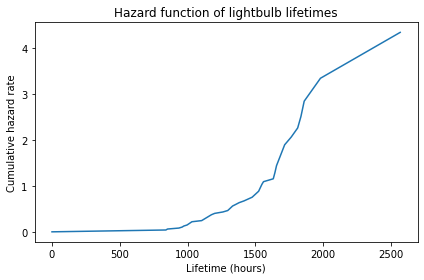

In [32]:
haz.cumsum().plot()

decorate(xlabel='Lifetime (hours)', 
         ylabel='Cumulative hazard rate', 
         title='Hazard function of lightbulb lifetimes')

The slope of the cumulative hazard function is proportional to the hazard rate, so we can use this curve to see when the hazard rate is low or high, and when it is increasing or decreasing.

Between 0 and 1000 hours, the slope is low, so the hazard rate is low.

Between 1000 and 2000 hours, the slope is increasing, so the hazard rate is increasing.

But notice that the vertical scale goes to 4.  You might wonder that that means; the answer is "not much".

The values of the hazard function are rates, that is, percentages of light bulbs that expire at each point in time.  When you add up these rates, the result does not have a clear interpretation.  

When you look at a cumulative hazard function, you should pay attention to the slope of the curve and ignore the values.

## Resampling

In the previous section, I suggested that we have to be careful not to overinterpret the right side of the hazard function, because it is based on a small number of data points.

To see how precise the estimated hazard function is, we can use resampling.

First I will use the Pmf of lifetimes to make a kernel density estimate (KDE) of the distribution.

In [33]:
from scipy.stats import gaussian_kde
?gaussian_kde

In [35]:
pmf.index

Int64Index([   0,  840,  852,  936,  960,  972,  996, 1008, 1032, 1104, 1176,
            1200, 1260, 1296, 1308, 1332, 1356, 1380, 1416, 1476, 1524, 1548,
            1560, 1632, 1644, 1656, 1716, 1764, 1812, 1836, 1860, 1980, 2568],
           dtype='int64', name='h')

In [36]:
   
kde = gaussian_kde(pmf.index, weights=pmf)
size = df['f'].sum()

We can use the KDE to draw a new sample of lifetimes, with the same size as the original data set, like this.

In [37]:
kde.resample(size).flatten()

array([ 952.31126921, 1864.42849308, 1433.63901114, 1295.19126319,
       1313.51752572, 1703.86013796, 1835.00199207, 1325.12447236,
       1274.97804616, 2012.69854508, 1068.49333996, 1861.73414574,
       1973.24127401, 1451.7947741 , 2048.90975212,  774.22829781,
       1763.05084232, 1659.60158002, 1298.07440999, 2037.48154462,
       1328.2828201 , 1327.46545677, 1013.17600494, 1334.92683333,
       1751.98727165, 1535.95349004,  930.83581418, 1696.42047508,
       1497.96192477, 1216.92359609, 1938.15529249, 1397.63112498,
       2889.37644682, 1571.63041188, 1515.8432514 ,  880.33071901,
       1572.85870863,  988.75706969, 1519.52725038, 1417.55562113,
       1181.05386081, 1673.13282542, 1002.35725793, 1757.53025408,
       2529.3026807 , 1685.52190306, 1357.11967037, 1639.33442458,
        919.4449098 , 2402.73434159])

In [38]:
sample = kde.resample(size).flatten()
sample.shape

(50,)

The following function takes a sample and computes its PMF, CDF, survival function, and hazard function.

In [39]:
pd.Series(sample).value_counts(normalize=True).sort_index()    

687.637972     0.02
869.208647     0.02
903.948775     0.02
938.020959     0.02
940.953066     0.02
966.079464     0.02
1026.607863    0.02
1049.138614    0.02
1055.649213    0.02
1100.441549    0.02
1111.404570    0.02
1137.998408    0.02
1148.267884    0.02
1168.209963    0.02
1171.957711    0.02
1176.225675    0.02
1188.112353    0.02
1190.422569    0.02
1243.928048    0.02
1249.636636    0.02
1260.866557    0.02
1320.268717    0.02
1331.469331    0.02
1341.184396    0.02
1387.734498    0.02
1409.001315    0.02
1412.925502    0.02
1417.793562    0.02
1426.098709    0.02
1429.456215    0.02
1445.857147    0.02
1462.998200    0.02
1483.605505    0.02
1486.011202    0.02
1531.573802    0.02
1571.471163    0.02
1587.915286    0.02
1625.870495    0.02
1627.682162    0.02
1635.069027    0.02
1652.251108    0.02
1663.576610    0.02
1709.602347    0.02
1747.213080    0.02
1760.465655    0.02
1811.766811    0.02
1875.858076    0.02
2009.454014    0.02
2883.784149    0.02
2923.648832    0.02


In [40]:
def make_hazard(sample):
    pmf = pd.Series(sample).value_counts(normalize=True).sort_index()    
    cdf = pmf.cumsum()
    surv = 1 - cdf
    haz = pmf / (pmf + surv)
    return pmf, cdf, surv, haz

I'll generate 100 samples and plot their survival functions.

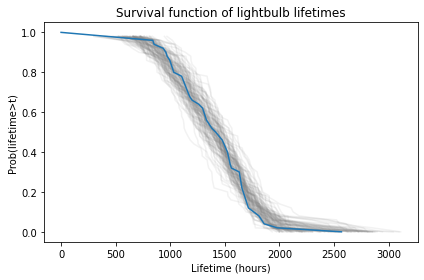

In [41]:
for i in range(100):
    sample = kde.resample(size).flatten()
    _, _, sf, _ = make_hazard(sample)
    sf.plot(color='gray', alpha=0.1)
    
surv.plot()
decorate(xlabel='Lifetime (hours)', 
         ylabel='Prob(lifetime>t)', 
         title='Survival function of lightbulb lifetimes')

By plotting the resampled survival functions on top of each other, we can get a sense of how much the results vary due to random sampling.

We can do the same thing with the hazard function:

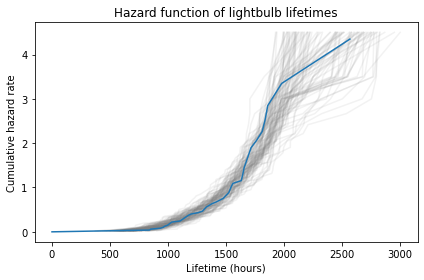

In [42]:
for i in range(100):
    sample = kde.resample(size).flatten()
    _, _, _, hf = make_hazard(sample)
    hf.cumsum().plot(color='gray', alpha=0.1)

haz.cumsum().plot()

decorate(xlabel='Lifetime (hours)', 
         ylabel='Cumulative hazard rate', 
         title='Hazard function of lightbulb lifetimes')

This plot gives us a sense of which parts of the cumulative hazard function are reliable and which are not.

Below 2000 hours, all of the resampled curves are similar; they increase with increasing slope.

After that, the variability of the curves is much wider, which means we don't have enough data to characterize this part of the hazard function.

## Summary

We have seen four ways to represent a distribution of lifetimes:

* Probability mass function (PMF), which maps from each value in the distribution to its probability.

* Cumulative distribution function (CDF), which maps from each value, `x`, to its cumulative probability, that is, the probability of being less than or equal to `x`.

* Survival function, which is the complement of the CDF; that is, the probability of exceeding `x`.

* Hazard function, which is the number of failures at `x` as a fraction of the number of cases that survive until `x`.

These representations are equivalent in the sense that they all contain the same information.  Given any of them, we can compute any of the others.

In this notebook, we computed the `Pmf` directly from the data, then computed the `Cdf`, survival function, and hazard function, in that order.

In the next notebook we will use these representations to deal with a case where we cannot compute the PMF directly from the data.

Part of [Survival Analysis in Python](https://allendowney.github.io/SurvivalAnalysisPython/)

Allen B. Downey

[Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)